In [1]:
%%capture
! pip install librosa
! pip install torch

In [2]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from CustomDataset import CustomDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from Misc import Misc
from EuclideanDistanceLoss import EuclideanDistanceLoss
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"

# Dimensions of the living room
X_MIN = -4000
X_MAX = 500
Y_MIN = -4000
Y_MAX = 2000
MISC = Misc(start_time=0, end_time=50000, sr=44100, target_sr=16000)
EUCLIDEAN_LOSS = EuclideanDistanceLoss()

## Read Data

In [4]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [5]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)


## Normalize Coordinates

In [6]:
def normalize_coordinates(centroids):
    room_width = X_MAX - X_MIN
    room_height = Y_MAX - Y_MIN

    centroids[:, 0] = (centroids[:, 0] - X_MIN) / room_width
    centroids[:, 1] = (centroids[:, 1] - Y_MIN) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## Preprocessing

In [7]:
preprocessed_data_mfcc_h1, preprocessed_data_rms_h1, preprocessed_data_zcr_h1, preprocessed_data_mel_h1 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h1)
preprocessed_data_mfcc_h2, preprocessed_data_rms_h2, preprocessed_data_zcr_h2, preprocessed_data_mel_h2 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h2)

100%|██████████| 104/104 [00:03<00:00, 33.75it/s]


In [8]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 98)
Preprocessed MFCC Human 1 data:  (1000, 4, 20, 98)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 98)
Preprocessed MFCC Human 2 data:  (104, 4, 20, 98)


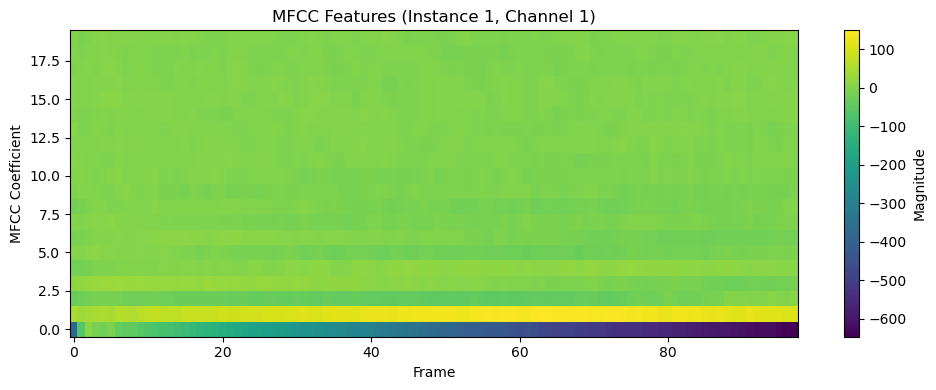

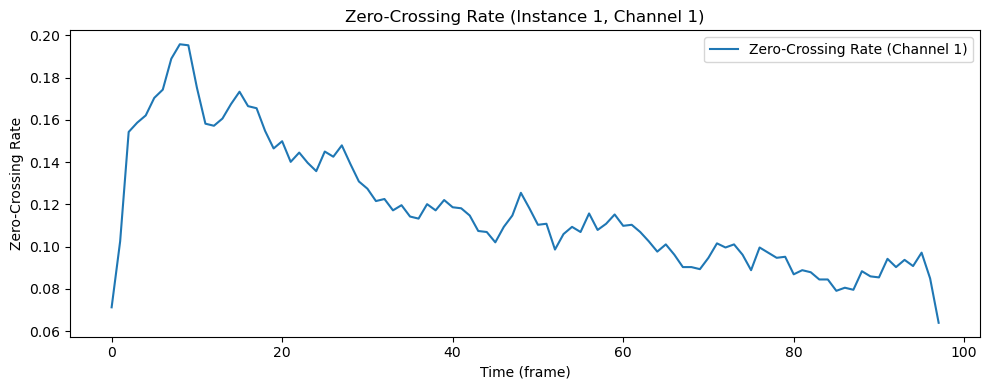

(128, 98)


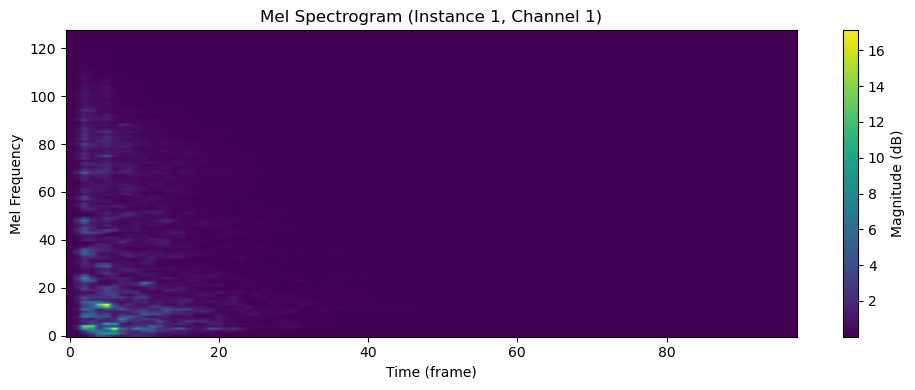

In [12]:
# Plot MFCC features for each instance and channel
for instance_index in range(preprocessed_data_mfcc_h2.shape[0]):
    for channel_index in range(preprocessed_data_mfcc_h2.shape[1]):
        mfcc_features = preprocessed_data_mfcc_h2[instance_index, channel_index]
        MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, mfcc=mfcc_features)
        break
    break

# Plot ZCR features for each instance and channel
for instance_index in range(preprocessed_data_zcr_h2.shape[0]):
    for channel_index in range(preprocessed_data_zcr_h2.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr_h2[instance_index, channel_index] 
        MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, zcr=zero_crossing_rate)
        break
    break

# Plot MEL features for each instance and channel
for instance_index in range(preprocessed_data_mel_h2.shape[0]):
    for channel_index in range(preprocessed_data_mel_h2.shape[1]):
        mel = preprocessed_data_mel_h2[instance_index, channel_index] 
        print(mel.shape)
        MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, mel=mel)
        break
    break

## Dataset

In [ ]:
dataset_h1 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h1, coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h2, coordinates=centroids_h2)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print("Features List Length:", len(features_list))
print("Features Shape (Microphone 1):", features_list[0])
print("Features Shape (Microphone 2):", features_list[1])
print("Features Shape (Microphone 3):", features_list[2])
print("Features Shape (Microphone 4):", features_list[3])
print("Coordinates:", coordinates)

## Linear Regression Model

In [ ]:
class MyLinearRegression(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(MyLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
batch_size = 64
train_loader = DataLoader(dataset=dataset_h1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset_h2, batch_size=batch_size, shuffle=False)

## Training

In [ ]:
input_size = 4  # 4 microphones
output_size = 2  # x, y coordinates

# Models
pytorch_model = MyLinearRegression(input_size=input_size, output_size=output_size)
sk_learn_model = LinearRegression()

criterion = EUCLIDEAN_LOSS
optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=0.0001)
num_epochs = 20

In [ ]:
# Scikit Learn Model
sk_learn_model.fit(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates)

# Pytorch Model
for epoch in range(num_epochs):
    pytorch_model.train()
    train_loss = 0.0
    for rms, coordinates in train_loader:
        optimizer.zero_grad()
        outputs = pytorch_model(rms)
        loss = criterion(outputs, coordinates)
        loss.backward()

## Predictions

### Scikit learn Model

In [ ]:
# Make predictions on the validation set
predicted_coordinates = sk_learn_model.predict(dataset_h2.preprocessed_data_rms)
true_coordinates = np.array(dataset_h2.coordinates)

# Calculate localization errors for each prediction
errors = []
for pred_coords, true_coords in zip(predicted_coordinates, true_coordinates):
    error = criterion(torch.tensor(pred_coords), torch.tensor(true_coords))
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))

### Pytorch Model

In [ ]:
pytorch_model.eval()
predicted_coordinates_pytorch = []
true_coordinates_pytorch = dataset_h2.coordinates

for rms, coordinates in dataset_h2:
    # Forward pass to get the predicted coordinates
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = pytorch_model(torch.tensor(rms))
    
    # Append the predicted coordinates to the list
    predicted_coordinates_pytorch.append(outputs)

# Convert the list of predicted coordinates to a single tensor
predicted_coordinates_pytorch = np.array(predicted_coordinates)

errors = []
for pred_coords, true_coords in zip(predicted_coordinates_pytorch, true_coordinates_pytorch):
    error = criterion(torch.tensor(pred_coords), torch.tensor(true_coords))
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))

## Plot Predictions

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(true_coordinates[:, 0], true_coordinates[:, 1], label='True Coordinates', marker='o', alpha=0.5)
plt.scatter(predicted_coordinates[:, 0], predicted_coordinates[:, 1], label='Predicted Coordinates', marker='x', alpha=0.5)
plt.title('True vs Predicted Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

## Zero-Crossing Rate

In [ ]:
dataset_h1 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h1, _type="zcr", coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h2, _type="zcr", coordinates=centroids_h2)

# Split the data into training and testing sets
rms_features = np.sqrt(np.mean(dataset_h1.preprocessed_data_zcr**2, axis=-1))
X_train = rms_features.reshape(1000, 4)
y_train = dataset_h1.coordinates
rms_features = np.sqrt(np.mean(dataset_h2.preprocessed_data_zcr**2, axis=-1))
X_test = rms_features.reshape(104, 4)
y_test = dataset_h2.coordinates

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
# print("Score: ", model.score(X_test, y_test))

errors = []
for pred_coords, true_coords in zip(y_pred, dataset_h2.coordinates):
    error = criterion(torch.tensor(pred_coords), torch.tensor(true_coords))
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(dataset_h2.coordinates[:, 0], dataset_h2.coordinates[:, 1], label='True Coordinates', marker='o', alpha=0.5)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label='Predicted Coordinates', marker='x', alpha=0.5)
plt.title('True vs Predicted Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()